# Import

In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

%matplotlib inline
from scipy.stats import norm
import numpy as np
from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import copy

# STEP1. 데이터 구하기   
주식데이터: [나스닥 데이터](https://finance.yahoo.com/quote/NQ=F?p=NQ=F)

In [2]:
csv_file = os.getenv('HOME') + '/aiffel/anomaly_detection/nasdaq/NQ=F.csv'

df= pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


In [3]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [4]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6171
삭제 후 데이터 길이(일자수): 5099


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# STEP2. 기본 통계분석으로 이상치 찾기   
- 데이터의 분포를 그려보기   
- z-test로 정규분포를 만족하는지 확인하기   
- (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기   

한 단계 더 나아가기
왜 이상치로 분류됐는지 해석해보기
탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
이상치들을 제거/교정해야할지 내버려둘지 고민하기

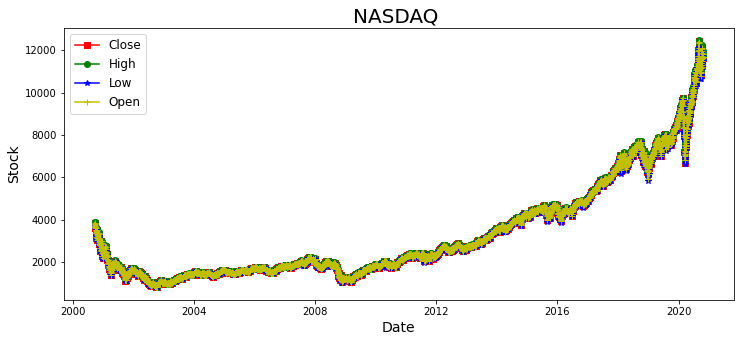

In [5]:
plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

0.0


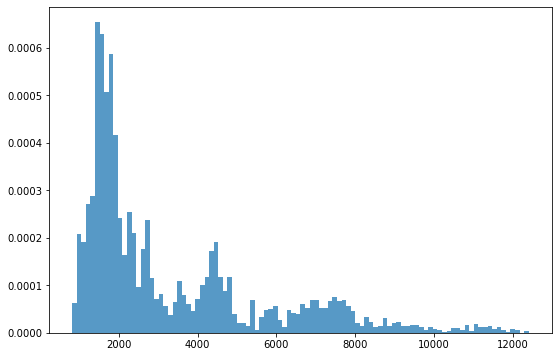

In [6]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

_, p = ztest(df.Close)
print(p)

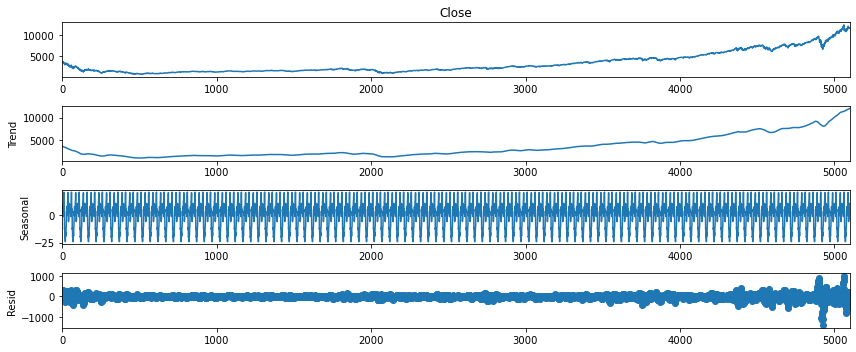

In [7]:
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

<AxesSubplot:>

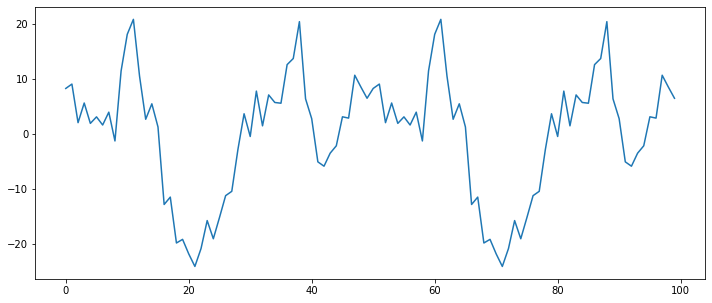

In [8]:
result.seasonal[:100].plot()

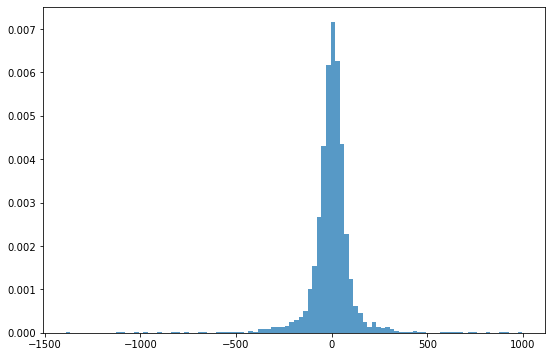

In [9]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [10]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8293684289676555 0.40689596053272026


In [11]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.2746671041805928 표준편차: 109.74677944784854
이상치 갯수: 91


In [12]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5084   2020-10-06
5085   2020-10-07
5096   2020-10-22
5097   2020-10-23
5098   2020-10-25
Name: Date, Length: 91, dtype: datetime64[ns]

# STEP3. Unsupervised Clustering 으로 이상치 찾기   
- k-means로 분석하기




In [13]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000
mean,3332.330515,3363.855636,3300.112357,3334.218037,288130.457813
std,2403.391909,2425.438358,2382.103731,2407.331221,109938.917287
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.475000,1597.732500,1571.207500,1584.428000,220602.630000
50%,2264.890000,2292.520000,2232.222500,2265.365898,268966.970000
75%,4434.496250,4466.726250,4401.212500,4435.423750,319713.305000
max,12033.042071,12196.758183,11862.766066,12040.730510,776809.340000


In [14]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000
mean,-1.341047,-1.436430,-1.201028,-1.299648,35.112663
std,112.064170,101.990343,116.234926,109.899954,110921.239658
min,-1280.680386,-1494.834833,-1227.054745,-1390.298634,-602851.363981
25%,-38.166494,-35.401395,-38.041929,-37.787638,-53443.762038
50%,3.303978,3.272212,4.016028,3.027842,-618.703185
75%,40.134378,37.577100,42.095358,40.892594,51444.891224
max,996.974738,933.595120,944.632966,996.335354,810593.111569


In [15]:
scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[-1.34104664 -1.43643019 -1.20102759 -1.29964831 35.11266287]


array([[ 0.95049097,  0.84696955,  0.81889464,  0.60269181,  0.0830647 ],
       [ 0.49107995,  1.28497335,  1.39116042,  2.09847415,  0.10434514],
       [ 1.91066005,  2.0195931 ,  2.05216731,  2.74173362, -0.08871354],
       ...,
       [-2.82945994, -4.24225564, -2.8223235 , -3.267196  ,  0.36169204],
       [-3.12271671, -4.8175975 , -2.63242983, -3.36514618,  0.44734492],
       [-3.65110382, -5.52397849, -2.58820859, -3.87260431, -4.64678486]])

In [16]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [17]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1060 4039]


In [18]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:961',
 'group:1-count:54',
 'group:2-count:917',
 'group:3-count:105',
 'group:4-count:640',
 'group:5-count:215',
 'group:6-count:476',
 'group:7-count:11',
 'group:8-count:20',
 'group:9-count:71',
 'group:10-count:253',
 'group:11-count:112',
 'group:12-count:266',
 'group:13-count:346',
 'group:14-count:652']

- DBSCAN으로 분석하기

In [19]:
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [20]:
print(clustering.labels_)

[ 0  0  0 ... 23 23 -1]


In [21]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:197',
 'group:0-count:4843',
 'group:1-count:2',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:3',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:3',
 'group:21-count:2',
 'group:22-count:2',
 'group:23-count:2']

# STEP 4. LSTM 오토인코더로 이상치 찾기
- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기   


In [22]:
tf.random.set_seed(777)
np.random.seed(777)

In [23]:
# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [24]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [25]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [26]:
checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [27]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
158/160 [============================>.] - ETA: 0s - loss: 3.2573 - mae: 3.2573
Epoch 00001: val_loss improved from inf to 2.45634, saving model to /home/aiffel/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
160/160 [==============================] - 5s 29ms/step - loss: 3.2226 - mae: 3.2226 - val_loss: 2.4563 - val_mae: 2.4563
Epoch 2/50
159/160 [============================>.] - ETA: 0s - loss: 0.6848 - mae: 0.6848
Epoch 00002: val_loss improved from 2.45634 to 0.87661, saving model to /home/aiffel/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
160/160 [==============================] - 4s 27ms/step - loss: 0.6818 - mae: 0.6818 - val_loss: 0.8766 - val_mae: 0.8766
Epoch 3/50
159/160 [============================>.] - ETA: 0s - loss: 0.4033 - mae: 0.4033
Epoch 00003: val_loss improved from 0.87661 to 0.59216, saving model to /home/aiffel/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
160/160 [==============================] - 4s 27ms/step - loss: 0.4024 - mae: 0.4024 - val_loss: 

In [28]:
model.load_weights(checkpoint_path)

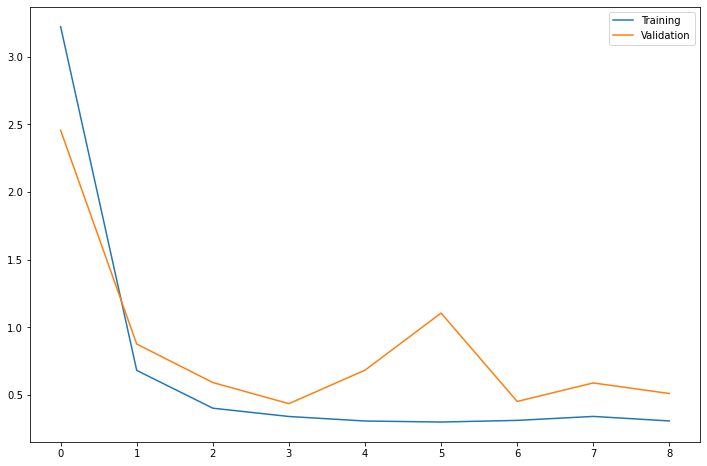

In [29]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

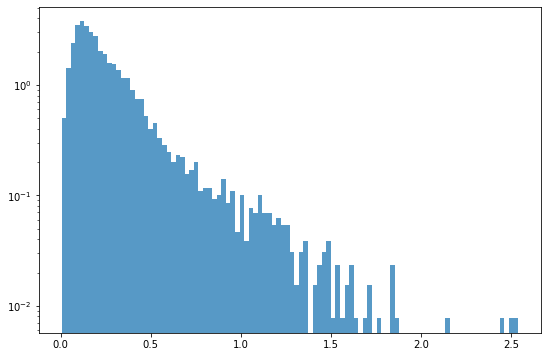

In [30]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [31]:
test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1747,2007-08-16,1877.500000,1878.75,1813.750000,1856.500000,1856.500000,982573.0,1.221298
1806,2007-11-08,2175.000000,2180.00,2081.000000,2105.500000,2105.500000,884081.0,1.100879
1854,2008-01-23,1809.500000,1812.00,1698.250000,1807.500000,1807.500000,888037.0,1.050994
2035,2008-10-10,1281.750000,1326.25,1198.250000,1282.500000,1282.500000,829115.0,1.077469
2740,2011-08-08,2145.000000,2170.75,2031.500000,2038.000000,2038.000000,731047.0,1.009712
...,...,...,...,...,...,...,...,...
5078,2020-10-12,11722.799805,12197.00,11687.799805,12098.200195,12098.200195,756438.0,1.175949
5079,2020-10-13,12100.000000,12249.00,12019.000000,12094.000000,12094.000000,754735.0,1.341999
5080,2020-10-14,12079.799805,12178.00,11901.799805,11974.200195,11974.200195,597198.0,1.059167
5082,2020-10-16,11891.000000,12022.00,11792.000000,11798.000000,11798.000000,527026.0,1.075589


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


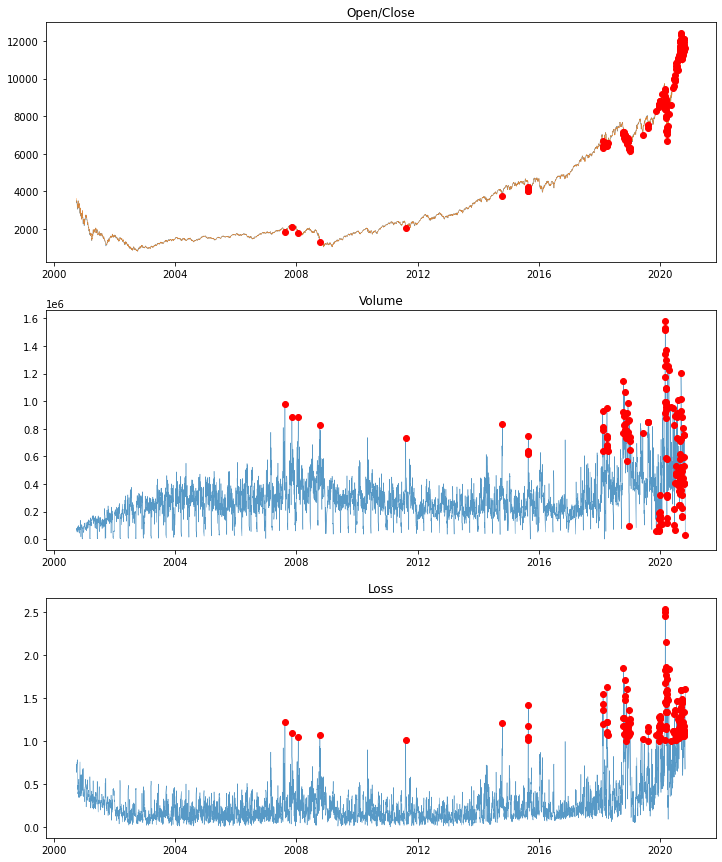

In [32]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])